# Prediction of Credit Card Default

### Excercice de prediction en rapport avec les cartes de credits

<a id='imp'></a>
## Importing packages and loading data

In [4]:
# here we will import the libraries used for machine learning
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O, data manipulation 
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from pandas import set_option
plt.style.use('ggplot') # nice plots

from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.linear_model import LogisticRegression # to apply the Logistic regression
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold # for cross validation
from sklearn.model_selection import GridSearchCV # for tuning parameter
from sklearn.model_selection import RandomizedSearchCV  # Randomized search on hyper parameters.
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestClassifier
#import xgboost as xgb
#from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import os
#print(os.listdir("../input"))

In [3]:
data = pd.read_csv('data\ccdefault.csv')
data.sample(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
25179,25180,50000,2,3,2,23,0,0,0,0,...,15088,-574,27529,1500,2000,6700,5000,28103,1032,0
23479,23480,100000,2,2,2,31,0,0,0,0,...,97486,97604,97241,3309,4421,5486,3400,3541,3894,1
6807,6808,30000,1,1,2,45,0,0,0,0,...,16065,930,780,1850,4700,1000,930,0,0,0
4394,4395,360000,1,1,1,59,-2,-2,-2,-1,...,71028,5019,28028,5095,5048,72133,25,28168,18758,0
29126,29127,70000,2,3,1,53,2,0,0,0,...,47581,48805,50018,3000,3200,2000,2000,2000,2000,1


<a id='fe'></a>
## Feature engineering

The data has been already encoded and cleaned. However, some categorical data have repeated categories. For instance, the variable ‘education’ has three categories with similar information:<br>
4: others, 5: unknown, and 6: unknown<br>

In [5]:
data.rename(columns={"DEFAULT": "Default"}, inplace=True)
data.drop('ID', axis = 1, inplace =True) # drop column "ID"
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  30000 non-null  int64
 1   SEX        30000 non-null  int64
 2   EDUCATION  30000 non-null  int64
 3   MARRIAGE   30000 non-null  int64
 4   AGE        30000 non-null  int64
 5   PAY_0      30000 non-null  int64
 6   PAY_2      30000 non-null  int64
 7   PAY_3      30000 non-null  int64
 8   PAY_4      30000 non-null  int64
 9   PAY_5      30000 non-null  int64
 10  PAY_6      30000 non-null  int64
 11  BILL_AMT1  30000 non-null  int64
 12  BILL_AMT2  30000 non-null  int64
 13  BILL_AMT3  30000 non-null  int64
 14  BILL_AMT4  30000 non-null  int64
 15  BILL_AMT5  30000 non-null  int64
 16  BILL_AMT6  30000 non-null  int64
 17  PAY_AMT1   30000 non-null  int64
 18  PAY_AMT2   30000 non-null  int64
 19  PAY_AMT3   30000 non-null  int64
 20  PAY_AMT4   30000 non-null  int64
 21  PAY_AMT5   3

In [4]:
# Separating features and target
y = data.Default     # target default=1 or non-default=0
features = data.drop('Default', axis = 1, inplace = False)

In [5]:
data['EDUCATION'].unique()

array([2, 1, 3, 5, 4, 6, 0])

The categories 4:others, 5:unknown, and 6:unknown can be grouped into a single class '4'.

In [6]:
data['EDUCATION']=np.where(data['EDUCATION'] == 5, 4, data['EDUCATION'])
data['EDUCATION']=np.where(data['EDUCATION'] == 6, 4, data['EDUCATION'])
data['EDUCATION']=np.where(data['EDUCATION'] == 0, 4, data['EDUCATION'])

After grouping, the education column has the following categories:

In [7]:
data['EDUCATION'].unique()

array([2, 1, 3, 4])

Similarly, the column 'marriage' should have three categories: 1 = married, 2 = single, 3 = others but it contains a category '0' which will be joined to the category '3'.

In [8]:
data['MARRIAGE'].unique()

array([1, 2, 3, 0])

In [9]:
data['MARRIAGE']=np.where(data['MARRIAGE'] == 0, 3, data['MARRIAGE'])
data['MARRIAGE'].unique()

array([1, 2, 3])

<a id='eda'></a>
## Exploratory Data Analysis (EDA)

<a id='map'></a>
### Mapping the target: categorizing

Among 30,000 credit card holders, we found 6,636 default credit cards; that is, the proportion of default in the data is 22,1%.

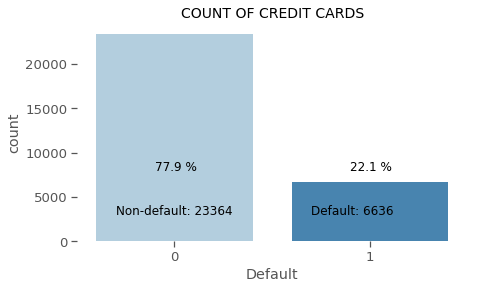

In [10]:
# The frequency of defaults
yes = data.Default.sum()
no = len(data)-yes

# Percentage
yes_perc = round(yes/len(data)*100, 1)
no_perc = round(no/len(data)*100, 1)

import sys 
plt.figure(figsize=(7,4))
sns.set_context('notebook', font_scale=1.2)
sns.countplot('Default',data=data, palette="Blues")
plt.annotate('Non-default: {}'.format(no), xy=(-0.3, 15000), xytext=(-0.3, 3000), size=12)
plt.annotate('Default: {}'.format(yes), xy=(0.7, 15000), xytext=(0.7, 3000), size=12)
plt.annotate(str(no_perc)+" %", xy=(-0.3, 15000), xytext=(-0.1, 8000), size=12)
plt.annotate(str(yes_perc)+" %", xy=(0.7, 15000), xytext=(0.9, 8000), size=12)
plt.title('COUNT OF CREDIT CARDS', size=14)
#Removing the frame
plt.box(False);

<a id='stat'></a>
### Descriptive Statistics
Below find the table where you can see the descriptive statistics of the variables of this dataset.

In [11]:
set_option('display.width', 100)
set_option('precision', 2)

print("SUMMARY STATISTICS OF NUMERIC COLUMNS")
print()
print(data.describe().T)

SUMMARY STATISTICS OF NUMERIC COLUMNS

             count       mean    ...           75%       max
LIMIT_BAL  30000.0  167484.32    ...     240000.00  1.00e+06
SEX        30000.0       1.60    ...          2.00  2.00e+00
EDUCATION  30000.0       1.84    ...          2.00  4.00e+00
MARRIAGE   30000.0       1.56    ...          2.00  3.00e+00
AGE        30000.0      35.49    ...         41.00  7.90e+01
PAY_0      30000.0      -0.02    ...          0.00  8.00e+00
PAY_2      30000.0      -0.13    ...          0.00  8.00e+00
PAY_3      30000.0      -0.17    ...          0.00  8.00e+00
PAY_4      30000.0      -0.22    ...          0.00  8.00e+00
PAY_5      30000.0      -0.27    ...          0.00  8.00e+00
PAY_6      30000.0      -0.29    ...          0.00  8.00e+00
BILL_AMT1  30000.0   51223.33    ...      67091.00  9.65e+05
BILL_AMT2  30000.0   49179.08    ...      64006.25  9.84e+05
BILL_AMT3  30000.0   47013.15    ...      60164.75  1.66e+06
BILL_AMT4  30000.0   43262.95    ...      5450

The credit card limit average amount is 167,484 NT dollars. The standard deviation is 129,747 NT dollars, ranging from 10,000 to 1M NT dollars.<br>
Education level is mostly graduate school (1) and university (2). Most of the clients are either marrined or single (less frequent the other status). Average age is 35.5 years, with a standard deviation of 9.2 years.

### Frequency of meaningful variables by defaulted and non-defaulted cards

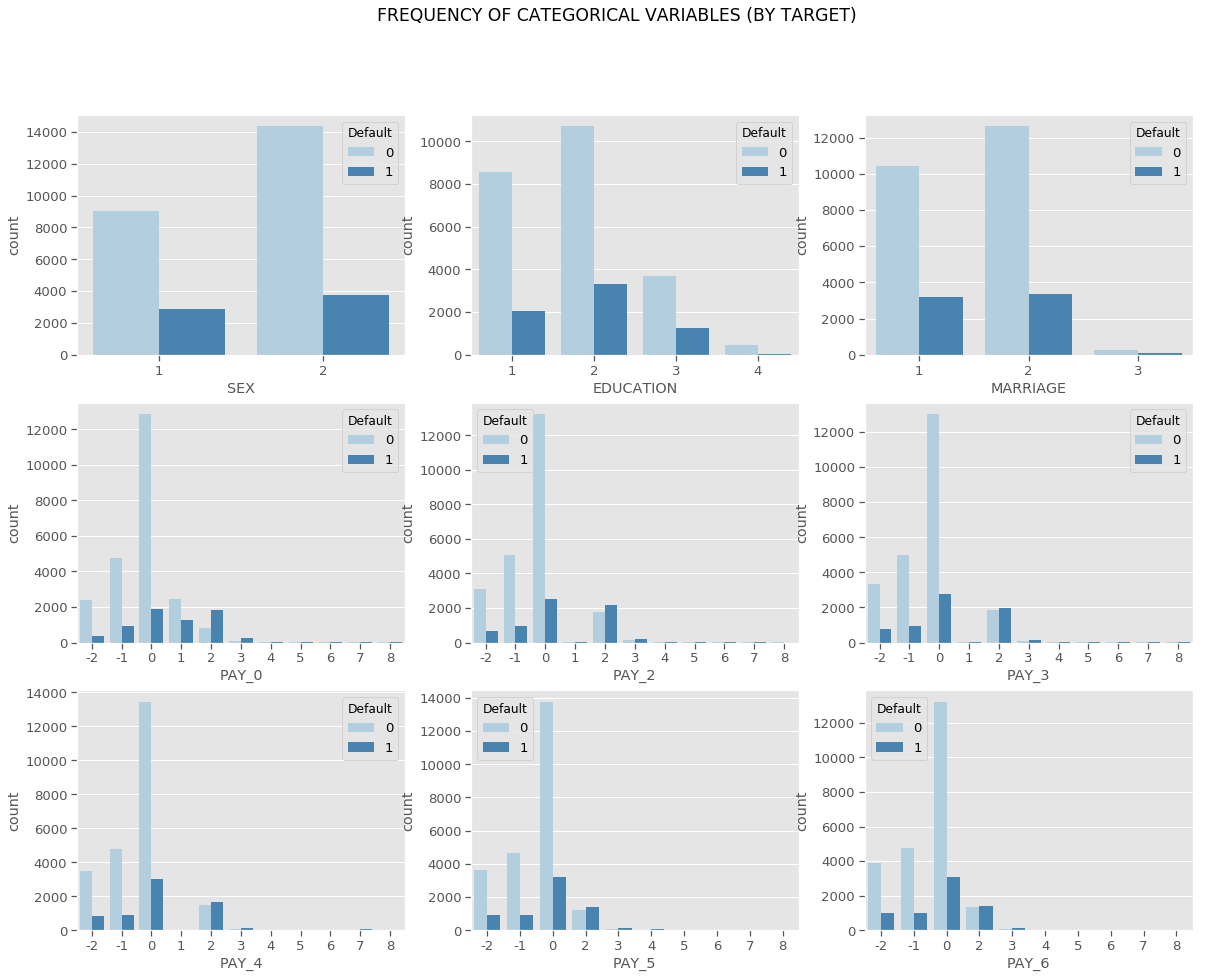

In [12]:
# Creating a new dataframe with categorical variables
subset = data[['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 
               'PAY_5', 'PAY_6', 'Default']]

f, axes = plt.subplots(3, 3, figsize=(20, 15), facecolor='white')
f.suptitle('FREQUENCY OF CATEGORICAL VARIABLES (BY TARGET)')
ax1 = sns.countplot(x="SEX", hue="Default", data=subset, palette="Blues", ax=axes[0,0])
ax2 = sns.countplot(x="EDUCATION", hue="Default", data=subset, palette="Blues",ax=axes[0,1])
ax3 = sns.countplot(x="MARRIAGE", hue="Default", data=subset, palette="Blues",ax=axes[0,2])
ax4 = sns.countplot(x="PAY_0", hue="Default", data=subset, palette="Blues", ax=axes[1,0])
ax5 = sns.countplot(x="PAY_2", hue="Default", data=subset, palette="Blues", ax=axes[1,1])
ax6 = sns.countplot(x="PAY_3", hue="Default", data=subset, palette="Blues", ax=axes[1,2])
ax7 = sns.countplot(x="PAY_4", hue="Default", data=subset, palette="Blues", ax=axes[2,0])
ax8 = sns.countplot(x="PAY_5", hue="Default", data=subset, palette="Blues", ax=axes[2,1])
ax9 = sns.countplot(x="PAY_6", hue="Default", data=subset, palette="Blues", ax=axes[2,2]);

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


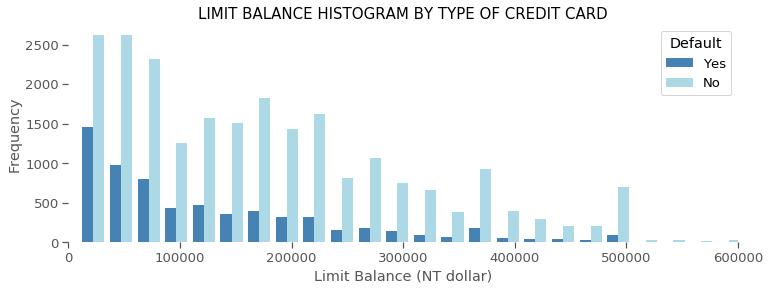

In [13]:
x1 = list(data[data['Default'] == 1]['LIMIT_BAL'])
x2 = list(data[data['Default'] == 0]['LIMIT_BAL'])

plt.figure(figsize=(12,4))
sns.set_context('notebook', font_scale=1.2)
#sns.set_color_codes("pastel")
plt.hist([x1, x2], bins = 40, normed=False, color=['steelblue', 'lightblue'])
plt.xlim([0,600000])
plt.legend(['Yes', 'No'], title = 'Default', loc='upper right', facecolor='white')
plt.xlabel('Limit Balance (NT dollar)')
plt.ylabel('Frequency')
plt.title('LIMIT BALANCE HISTOGRAM BY TYPE OF CREDIT CARD', SIZE=15)
plt.box(False)
plt.savefig('ImageName', format='png', dpi=200, transparent=True);

There are 30,000 credit card clients.

The credit card average amount limit is 167,484 NT dollars. The standard deviation is 129,747 NT dollars, ranging from 10,000 to 1M NT dollars.

Education level is mostly graduate school(1) and university(2).

Most of the clients are either marrined or single (less frequent the other status).

Average age is 35.5 years, with a standard deviation of 9.2.

As the value 0 for default payment means 'not default' and value 1 means 'default', the mean of 0.221 means that there are 22.1% of credit card contracts that will default next month (will verify this in the next sections of this analysis).

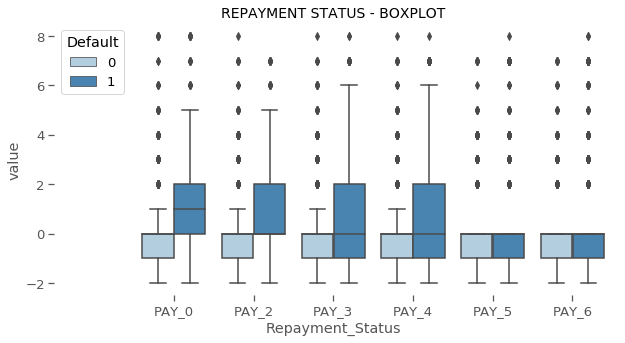

In [14]:
Repayment = data[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]

Repayment = pd.concat([y,Repayment],axis=1)
Repayment = pd.melt(Repayment,id_vars="Default",
                    var_name="Repayment_Status",
                    value_name='value')

plt.figure(figsize=(10,5))
sns.set_context('notebook', font_scale=1.2)
sns.boxplot(y="value", x="Repayment_Status", hue="Default", data=Repayment, palette='Blues')
plt.legend(loc='best', title= 'Default', facecolor='white')
plt.xlim([-1.5,5.5])
plt.title('REPAYMENT STATUS - BOXPLOT', size=14)
plt.box(False)
plt.savefig('ImageName', format='png', dpi=200);

It seems that PAY_0 (Repayment status in September) and PAY_2 (Repayment status in August)  have more discriminatory power the repayment status in other months.

<a id='std'></a>
### Standardizing and plotting the data
The boxplot below reveals that features are in different scales and units. Many models use some form of distance when making predictions, and therefore, it is recommended to normalize the data.

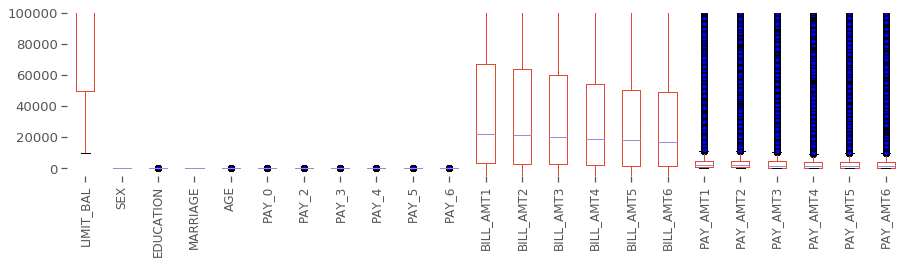

In [15]:
## data are distributed in a wide range (below), need to be normalizded.
plt.figure(figsize=(15,3))
ax= data.drop('Default', axis=1).boxplot(data.columns.name, rot=90)
outliers = dict(markerfacecolor='b', marker='p')
ax= features.boxplot(features.columns.name, rot=90, flierprops=outliers)
plt.xticks(size=12)
ax.set_ylim([-5000,100000])
plt.box(False);

We performed the standardization data; i.e, all features are centered around zero and have variance one. Features were plotted again, using a violin plot.

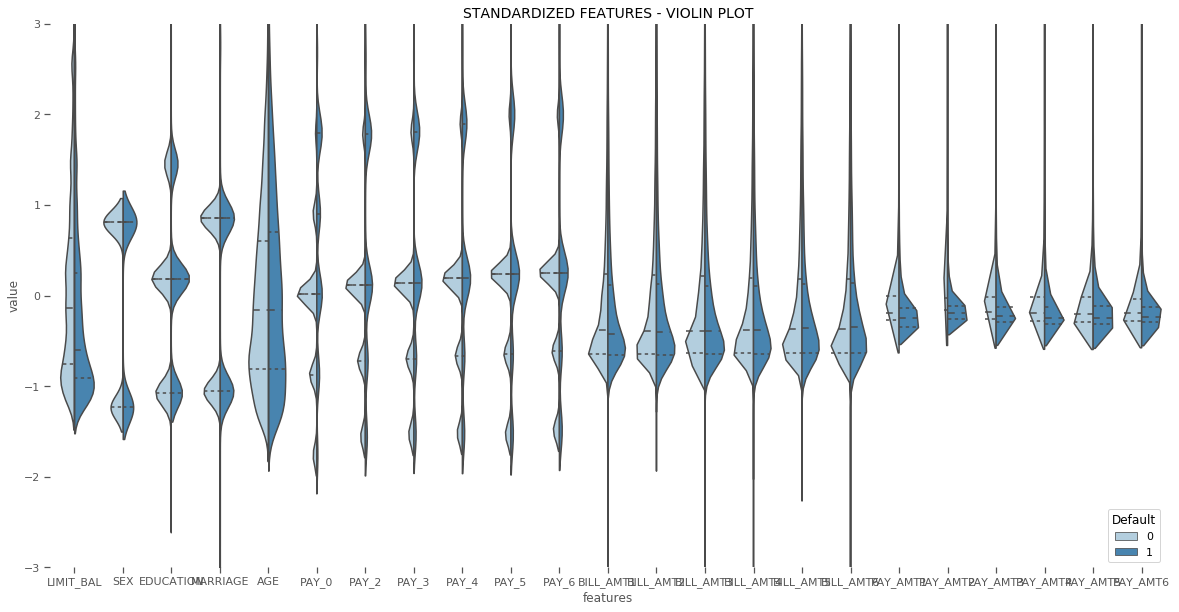

In [16]:
stdX = (features - features.mean()) / (features.std())              # standardization
data_st = pd.concat([y,stdX.iloc[:,:]],axis=1)
data_st = pd.melt(data_st,id_vars="Default",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(20,10))
sns.set_context('notebook', font_scale=1)
sns.violinplot(y="value", x="features", hue="Default", data=data_st,split=True, 
               inner="quart", palette='Blues')
plt.legend(loc=4, title= 'Default', facecolor='white')
plt.ylim([-3,3])
plt.title('STANDARDIZED FEATURES - VIOLIN PLOT', size=14)
plt.box(False)
plt.savefig('ImageName', format='png', dpi=200, transparent=False);

<a id='corr'></a>
### Correlation
A correlation matrix of all variables is shown in the heatmap below. The only feature with a notable positive correlation with the dependent variable ‘Default’ is re-payment status during the last month (September). The highest negative correlation with default occurs with Limit_Balance, indicating that customers with lower limit balance are more likely to default. It can also be observed that some variables are highly correlated to each other, that is the case of the amount of bill statement and the repayment status in different months.

Looking at correlations matrix, defined via Pearson function. 

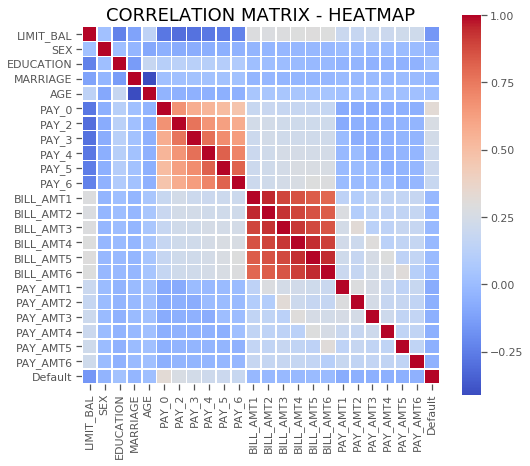

In [17]:
#  looking at correlations matrix, defined via Pearson function  
corr = data.corr() # .corr is used to find corelation
f,ax = plt.subplots(figsize=(8, 7))
sns.heatmap(corr, cbar = True,  square = True, annot = False, fmt= '.1f', 
            xticklabels= True, yticklabels= True
            ,cmap="coolwarm", linewidths=.5, ax=ax)
plt.title('CORRELATION MATRIX - HEATMAP', size=18);

The heatmat shows that features are correlated with each other (collinearity), such us like PAY_0,2,3,4,5,6 and BILL_AMT1,2,3,4,5,6. In those cases, the correlation is positive.

Uncorrelated data are potentially more useful: discriminatory!

**What do correlations mean?**<br>

Lets separately fit correlated and uncorrelated data via linear regression: 

Uncorrelated data are poentially more useful: discrimentory!


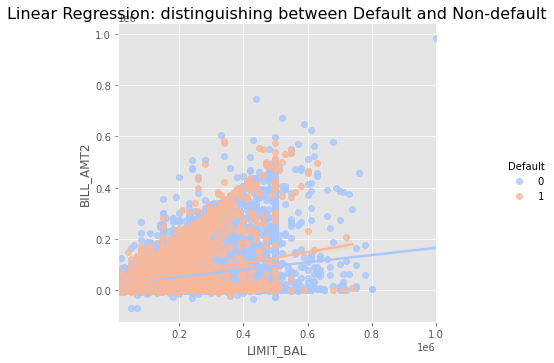

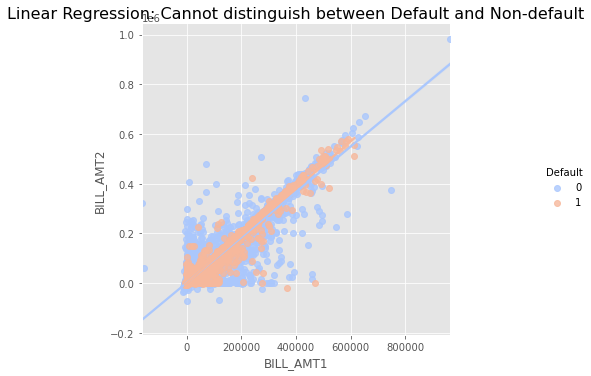

In [6]:
sns.lmplot(x='LIMIT_BAL', y= 'BILL_AMT2', data = data, hue ='Default', 
           palette='coolwarm')
plt.title('Linear Regression: distinguishing between Default and Non-default', size=16)


sns.lmplot(x='BILL_AMT1', y= 'BILL_AMT2', data = data, hue ='Default', 
           palette='coolwarm')
plt.title('Linear Regression: Cannot distinguish between Default and Non-default', size=16);

print('Uncorrelated data are poentially more useful: discrimentory!')

<a id='ml'></a>
## Machine Learning: Classification models

Logistic Regression, Decision Tree and Random Forest Classifier are our main drivers in this exercice classification.<br>

To build machine learning models the original data was divided into features (X) and target (y) and then split into train (80%) and test (20%) sets. Thus, the algorithms would be trained on one set of data and tested out on a completely different set of data (not seen before by the algorithm).

<a id='sp'></a>
### Spliting the data into train and test sets

In [19]:
# Original dataset
X = data.drop('Default', axis=1)  
y = data['Default']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)

In [20]:
# Dataset with standardized features
Xstd_train, Xstd_test, ystd_train, ystd_test = train_test_split(stdX,y, test_size=0.2, stratify=y,
                                                                random_state=42)

<a id='fs'></a>
### Feature Selection

#### Recursive Feature Elimination
Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and select either the best or wrong performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to choose features by recursively considering smaller and smaller sets of features.

In [21]:
NUM_FEATURES = 3
model = LogisticRegression()
rfe_stand = RFE(model, NUM_FEATURES)
fit_stand = rfe_stand.fit(stdX, y)
#print("St Model Num Features:", fit_stand.n_features_)
#print("St Model Selected Features:", fit_stand.support_)
print("Std Model Feature Ranking:", fit_stand.ranking_)
# calculate the score for the selected features
score_stand = rfe_stand.score(stdX,y)
print("Standardized Model Score with selected features is: %f (%f)" % (score_stand.mean(), score_stand.std()))

Std Model Feature Ranking: [ 7 15  9  8 10  1  6  4 18 11 21  1  5  2 20 13 19  3  1 14 12 16 17]
Standardized Model Score with selected features is: 0.812600 (0.000000)


In [22]:
feature_names = np.array(features.columns)
print('Most important features (RFE): %s'% feature_names[rfe_stand.support_])

Most important features (RFE): ['PAY_0' 'BILL_AMT1' 'PAY_AMT2']


* Repayment status in September (PAY_0)
* Amount of bill statement in September (BILL_AMT1)
* Amount of previous payments in August (PAY_AMT2)

In [23]:
# Dataset with three most important features
Ximp = stdX[['PAY_0', 'BILL_AMT1', 'PAY_AMT2']]
X_tr, X_t, y_tr, y_t = train_test_split(Ximp,y, test_size=0.2, stratify=y, random_state=42)

<a id='lr1'></a>
### Logistic Regression (original data)

Logistic Regression is one of the simplest algorithms which estimates the relationship between one dependent binary variable and independent variables, computing the probability of occurrence of an event. The regulation parameter C controls the trade-off between increasing complexity (overfitting) and keeping the model simple (underfitting). For large values of C, the power of regulation is reduced and the model increases its complexity, thus overfitting the data.<br>

The parameter ‘C’ was tuned using RandomizedSearchCV( ) for the different datasets: original, standardized and with most important features. Once the parameter ‘C’ was defined for each dataset, the logistic regression model initiated and then fitted to the training data, as it was described in the methodology.

In [24]:
# Setup the hyperparameter grid, (not scaled data)
param_grid = {'C': np.logspace(-5, 8, 15)}

# Instantiate a logistic regression classifier
logreg = LogisticRegression()

# Instantiate the RandomizedSearchCV object
logreg_cv = RandomizedSearchCV(logreg,param_grid , cv=5, random_state=0)

# Fit it to the data
logreg_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 

Tuned Logistic Regression Parameters: {'C': 8.483428982440725e-05}


Accuracy: 0.7788333333333334

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      4673
           1       0.00      0.00      0.00      1327

   micro avg       0.78      0.78      0.78      6000
   macro avg       0.39      0.50      0.44      6000
weighted avg       0.61      0.78      0.68      6000


Average 5-Fold CV Score: 0.7788 , Standard deviation: 0.0001


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


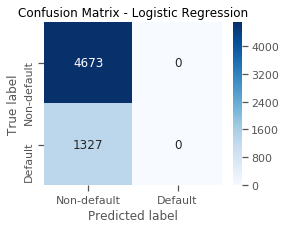

In [25]:
LR = LogisticRegression(C=0.00005, random_state=0)
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)
print('Accuracy:', metrics.accuracy_score(y_pred,y_test))

## 5-fold cross-validation 
cv_scores =cross_val_score(LR, X, y, cv=5)

# Print the 5-fold cross-validation scores
print()
print(classification_report(y_test, y_pred))
print()
print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)),
      ", Standard deviation: {}".format(round(np.std(cv_scores),4)))

plt.figure(figsize=(4,3))
ConfMatrix = confusion_matrix(y_test,LR.predict(X_test))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Logistic Regression");

The model has not power predicting default credit cards.this metrics is not appropriate for the evaluation of this problem.  However, it can be observed that the average accuracy of the model is about 78%. 

<a id='lr2'></a>
### Logistic Regression (standardized features)

In [26]:
# Instantiate the RandomizedSearchCV object:
logreg_cv_std = RandomizedSearchCV(logreg,param_grid , cv=5, random_state=0)

# Fit it to the standardized data
logreg_cv_std.fit(Xstd_train, ystd_train)

# Print the tuned parameters 
print("Tuned Logistic Regression Parameters with standardized features: {}".format(logreg_cv_std.best_params_)) 

Tuned Logistic Regression Parameters with standardized features: {'C': 3.727593720314938}


Accuracy: 0.8078333333333333

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.69      0.24      0.36      1327

   micro avg       0.81      0.81      0.81      6000
   macro avg       0.75      0.60      0.62      6000
weighted avg       0.79      0.81      0.77      6000


Average 5-Fold CV Score: 0.8099 , Standard deviation: 0.0047


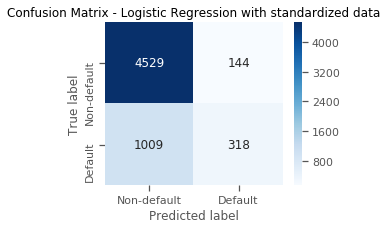

In [27]:
LRS = LogisticRegression(C=3.73, random_state=0)
LRS.fit(Xstd_train, ystd_train)
y_pred = LRS.predict(Xstd_test)
print('Accuracy:', metrics.accuracy_score(y_pred,ystd_test))

## 5-fold cross-validation 
cv_scores =cross_val_score(LRS, stdX, y, cv=5)

# Print the 5-fold cross-validation scores
print()
print(classification_report(ystd_test, y_pred))
print()
print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)),
      ", Standard deviation: {}".format(round(np.std(cv_scores),4)))

plt.figure(figsize=(4,3))
ConfMatrix = confusion_matrix(ystd_test,LRS.predict(Xstd_test))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Logistic Regression with standardized data");

The performance of the logistic regression model standardized data improved compared to the model built with the original dataset. By using the standardized dataset, the model is able to predict defaults; however, with a very low recall (0.24).

<a id='lr3'></a>
### Logistic Regression (most important features)

Accuracy: 0.8121666666666667

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.69      0.27      0.39      1327

   micro avg       0.81      0.81      0.81      6000
   macro avg       0.76      0.62      0.64      6000
weighted avg       0.79      0.81      0.78      6000


Average 5-Fold CV Score: 0.8118 , Standard deviation: 0.0064


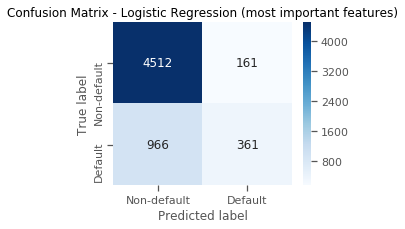

In [28]:
LR_imp = LogisticRegression(C=3.73, random_state=0)
LR_imp.fit(X_tr, y_tr)
y_pred = LR_imp.predict(X_t)
print('Accuracy:', metrics.accuracy_score(y_pred,y_t))

## 5-fold cross-validation 
cv_scores =cross_val_score(LR_imp, Ximp, y, cv=5)

# Print the 5-fold cross-validation scores
print()
print(classification_report(y_t, y_pred))
print()
print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)),
      ", Standard deviation: {}".format(round(np.std(cv_scores),4)))

plt.figure(figsize=(4,3))
ConfMatrix = confusion_matrix(y_t,LR_imp.predict(X_t))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Logistic Regression (most important features)");

When using just important features for building the model, there is a slight improvement in performance with respect to the previous model. Therefore, taking into account three features only, the model has the same predictive power than using 24 features. Thus, future strategies should be focused on: repayment status in September (PAY_0), amount of bill statement in September (BILL_AMT1), and amount of previous payments in August (PAY_AMT2).

<a id='tree'></a>
### Decision Tree Classifier
Decision Tree is also a good algorithm for classification problems because it is easy to interpret and understand. An internal node represents a feature, the branch represents a decision rule, and each leaf node represents the outcome. Some advantages of decision trees are that they require less data preprocessing, i.e., no need to normalize features. However, noisy data can be easily overfitted and results in biased results when the data set is imbalanced.

In [29]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [1,2,3,4,5,6,7,8,9],
              "max_features": [1,2,3,4,5,6,7,8,9],
              "min_samples_leaf": [1,2,3,4,5,6,7,8,9],
              "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree, param_distributions=param_dist, cv=5, random_state=0)

# Fit it to the data
tree_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))

Tuned Decision Tree Parameters: {'min_samples_leaf': 8, 'max_features': 7, 'max_depth': 4, 'criterion': 'entropy'}


Accuracy: 0.808

              precision    recall  f1-score   support

           0       0.83      0.94      0.88      4673
           1       0.63      0.33      0.43      1327

   micro avg       0.81      0.81      0.81      6000
   macro avg       0.73      0.64      0.66      6000
weighted avg       0.79      0.81      0.78      6000


Average 5-Fold CV Score: 0.8126 , Standard deviation: 0.0089


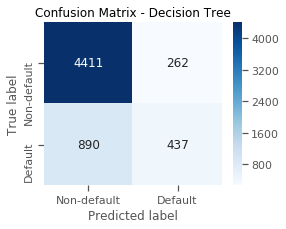

In [30]:
Tree = DecisionTreeClassifier(criterion= 'gini', max_depth= 7, 
                                     max_features= 9, min_samples_leaf= 2, 
                                     random_state=0)
Tree.fit(X_train, y_train)
y_pred = Tree.predict(X_test)
print('Accuracy:', metrics.accuracy_score(y_pred,y_test))

## 5-fold cross-validation 
cv_scores =cross_val_score(Tree, X, y, cv=5)

# Print the 5-fold cross-validation scores
print()
print(classification_report(y_test, y_pred))
print()
print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)), 
      ", Standard deviation: {}".format(round(np.std(cv_scores),4)))

plt.figure(figsize=(4,3))
ConfMatrix = confusion_matrix(y_test,Tree.predict(X_test))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Decision Tree");

The performance of the decision tree model improved compared to the logistic regression model showed previously. However, the recall is still low (0.33).

<a id='rf'></a>
### Random Forest Classifier
Random forest classifier is comprised of multiple decision trees. It creates different random subset of decision trees from the training set as its predictors and selects the best solution by means of voting. As a result, the Random Forest model avoids overfitting problems. 

In [31]:
# Create the random grid
param_dist = {'n_estimators': [50,100,150,200,250],
               "max_features": [1,2,3,4,5,6,7,8,9],
               'max_depth': [1,2,3,4,5,6,7,8,9],
               "criterion": ["gini", "entropy"]}

rf = RandomForestClassifier()

rf_cv = RandomizedSearchCV(rf, param_distributions = param_dist, 
                           cv = 5, random_state=0, n_jobs = -1)

rf_cv.fit(X, y)

print("Tuned Random Forest Parameters: %s" % (rf_cv.best_params_))

Tuned Random Forest Parameters: {'n_estimators': 200, 'max_features': 6, 'max_depth': 5, 'criterion': 'entropy'}


Accuracy: 0.8171666666666667

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.66      0.35      0.46      1327

   micro avg       0.82      0.82      0.82      6000
   macro avg       0.75      0.65      0.67      6000
weighted avg       0.80      0.82      0.79      6000


Average 5-Fold CV Score: 0.8204 , Standard deviation: 0.0096


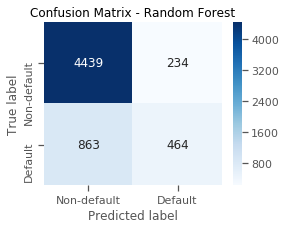

In [32]:
Ran = RandomForestClassifier(criterion= 'gini', max_depth= 6, 
                                     max_features= 5, n_estimators= 150, 
                                     random_state=0)
Ran.fit(X_train, y_train)
y_pred = Ran.predict(X_test)
print('Accuracy:', metrics.accuracy_score(y_pred,y_test))

## 5-fold cross-validation 
cv_scores =cross_val_score(Ran, X, y, cv=5)

# Print the 5-fold cross-validation scores
print()
print(classification_report(y_test, y_pred))
print()
print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)),
      ", Standard deviation: {}".format(round(np.std(cv_scores),4)))

plt.figure(figsize=(4,3))
ConfMatrix = confusion_matrix(y_test,Ran.predict(X_test))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Random Forest");

<a id='sum'></a>
## Comparison of model performance
The metrics used to evaluate performance of the different models: accuracy, precision, recall, f1-score, AUC (ROC), and confusion matrix were employed.

<a id='roc'></a>
### Receiver operating characteristic (ROC) Curve
Receiver Operating Characteristic (ROC) curve is a plot of the true positive rate against the false positive rate. The AUC is the Area Under Curve. If the AUC is high, the model is better distinguishing between positive and negative class. The ROC curve is plotted with “True Positive Rate” or Recall (on the y-axis) against the “False Positive Rate” (on the x-axis). When the AUC is 0.5 means that the model has no discrimination capacity to distinguish between positive and negative class.

The Receiver operating characteristic (ROC) Curve with the respective area under the curve (AUC) are shown below for each model.

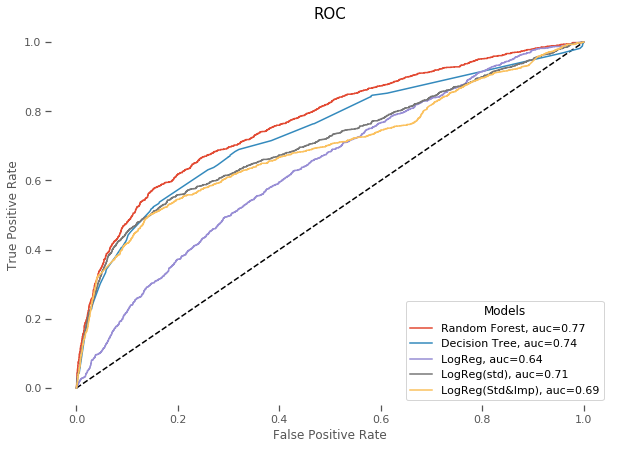

In [33]:
y_pred_proba_RF = Ran.predict_proba(X_test)[::,1]
fpr1, tpr1, _ = metrics.roc_curve(y_test,  y_pred_proba_RF)
auc1 = metrics.roc_auc_score(y_test, y_pred_proba_RF)

y_pred_proba_DT = Tree.predict_proba(X_test)[::,1]
fpr2, tpr2, _ = metrics.roc_curve(y_test,  y_pred_proba_DT)
auc2 = metrics.roc_auc_score(y_test, y_pred_proba_DT)

y_pred_proba_LR = LR.predict_proba(X_test)[::,1]
fpr3, tpr3, _ = metrics.roc_curve(y_test,  y_pred_proba_LR)
auc3 = metrics.roc_auc_score(y_test, y_pred_proba_LR)

y_pred_proba_LRS = LRS.predict_proba(Xstd_test)[::,1]
fpr4, tpr4, _ = metrics.roc_curve(ystd_test,  y_pred_proba_LRS)
auc4 = metrics.roc_auc_score(ystd_test, y_pred_proba_LRS)

y_pred_proba_LRimp = LR_imp.predict_proba(X_t)[::,1]
fpr5, tpr5, _ = metrics.roc_curve(y_t,  y_pred_proba_LRimp)
auc5 = metrics.roc_auc_score(y_t, y_pred_proba_LRimp)

plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1,tpr1,label="Random Forest, auc="+str(round(auc1,2)))
plt.plot(fpr2,tpr2,label="Decision Tree, auc="+str(round(auc2,2)))
plt.plot(fpr3,tpr3,label="LogReg, auc="+str(round(auc3,2)))
plt.plot(fpr4,tpr4,label="LogReg(std), auc="+str(round(auc4,2)))
plt.plot(fpr5,tpr5,label="LogReg(Std&Imp), auc="+str(round(auc5,2)))
plt.legend(loc=4, title='Models', facecolor='white')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC', size=15)
plt.box(False)
plt.savefig('ImageName', format='png', dpi=200, transparent=True);

The highest AUC is obtained for the Random Forest Classifier model, with a value of 0.77. This means there is 77% chance that the model will be able to distinguish between default class and non-default class.

<a id='ac'></a>
### Mean Accuracy (coss-validation)
Accuracy is the ratio of correctly predicted observation to the overall observations and it is one of the most intuitive measurements of performance. However, a high accuracy rate does not always mean we have a perfect model. In fact, it only works well when the datasets are symmetric. It can be misleading when classes are imbalanced.

Using K-fold cross-validation it is possible to obtain less biased models and avoid overfitting the data. In this case it was used a 5-fold cross-validation, as shown in the code below.

cv_scores = cross_val_score(Model, X, y, cv=5)

After cross-validation there are five values of accuracy, so it was calculated the mean and standard deviation of all results.

In [34]:
# Append different models
models = []

# Logistic Regression
models.append(('LogReg',
               LogisticRegression(C=3.73, random_state=0),'none'))

# Logistic Regression (with standardized data)
models.append(('LogReg(Std)',
               LogisticRegression(C=3.73, random_state=0),'Std'))

# Logistic Regression with standardized and important features
models.append(('LogReg(Std&Imp)',
               LogisticRegression(C=3.73, random_state=0),'imp'))

# Decision Tree
models.append(('Decision Tree', 
              DecisionTreeClassifier(criterion= 'entropy', max_depth= 4, 
                                     max_features= 7, min_samples_leaf= 8, 
                                     random_state=0),'none'))

# Random Forest Classifier
models.append(('Random Forest', 
              RandomForestClassifier(criterion= 'gini', max_depth= 6, 
                                     max_features= 5, n_estimators= 150, 
                                     random_state=0), 'none'))

# Evaluate each model
results = []
names = []
scoring = 'accuracy'

for name, model, Std in models:
    if Std == 'Std':
        cv_results = cross_val_score(model, stdX, y, cv=5, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)       
    elif Std == 'none':
        cv_results = cross_val_score(model, X, y, cv=5, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    else:
        cv_results = cross_val_score(model, Ximp, y, cv=5, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

LogReg: 0.778767 (0.000116)
LogReg(Std): 0.809934 (0.004719)
LogReg(Std&Imp): 0.811834 (0.006442)
Decision Tree: 0.815934 (0.006900)
Random Forest: 0.820367 (0.009564)


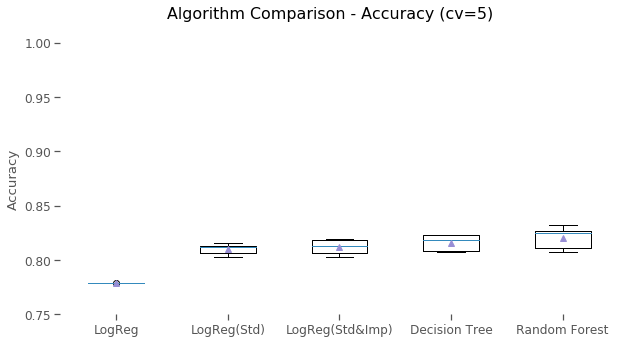

In [35]:
from matplotlib import pyplot
# Plot all the accuracy results vs. each model 
#(model type on the x-axis and accuracy on the y-axis).
fig = pyplot.figure(figsize=(10,5))
sns.set_context('notebook', font_scale=1.1)
fig.suptitle('Algorithm Comparison - Accuracy (cv=5)')
ax = fig.add_subplot(111)
pyplot.boxplot(results, showmeans=True)
ax.set_xticklabels(names)
ax.set_ylabel('Accuracy')
ax.set_ylim([0.75,1])
plt.box(False)
plt.savefig('ImageName', format='png', dpi=200, transparent=True);

The best accuracy is obtained for the Random Forest Classifier with a mean accuracy of 0.82, yet it is the model with higher variation (0.0096). In general, all models have comparable mean accuracy. Nevertheless, because the classes are imbalanced (the proportion of non-default credit cards is higher than default) this metric is misleading. Furthermore, accuracy does not consider the rate of false positives (non-default credits cards that were predicted as default) and false negatives (default credit cards that were incorrectly predicted as non-default). Both cases have negative impact on the bank, since false positives leads to unsatisfied customers and false negatives leads to financial loss. 

<a id='m'></a>
### Precision, Recall, F1-score
The precision of a model is the ratio TP / (TP + FP). In this case, it is the ability of the classifier not to label as positive a sample that is negative. Precision is a good metric to use when the costs of false positive (FP) is high.

The recall of a model is the ratio TP / (TP + FN). In this case, it is the ability of the classifier to find all the positive class. Recall is a good metric to use when the cost associated with false negative (FN) is high. In this classification problem there is a high cost for the bank when a default credit card is predicted as non-default, since no actions can be taken. Thus, recall is one important metric to pay attention to.

F1-score is a weighted average of precision and recall. Thus, it considers FP and FN. This metric is very useful when we have uneven class distribution, as it seeks a balance between precision and recall.

In [36]:
from astropy.table import Table, Column
data_rows = [('Logistic Regression', 'Standardized', 0.79, 0.81, 0.77),
              ('Logistic Regression', 'Important features', 0.79, 0.81, 0.78),
              ('Decision Tree', 'original', 0.80, 0.82, 0.79),
             ('Random Forest', 'original', 0.80, 0.82, 0.80)
            ]
t = Table(rows=data_rows, names=('Model', 'Data', 'Precision', 'Recall', 'F1'))
print(t)

       Model               Data        Precision Recall  F1 
------------------- ------------------ --------- ------ ----
Logistic Regression       Standardized      0.79   0.81 0.77
Logistic Regression Important features      0.79   0.81 0.78
      Decision Tree           original       0.8   0.82 0.79
      Random Forest           original       0.8   0.82  0.8
